In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]  # we only take the first two features.
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y ensures that the class distribution is preserved in both training and test sets

### 標準化

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # fit only on the training data
X_train_std = scaler.transform(X_train)  # transform training data
X_test_std = scaler.transform(X_test)  # transform test data using the same scaler

x_combined = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # マーカーとカラーマップの準備
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    # グリッドポイントの等高線をプロット
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)

    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # クラスごとに訓練データをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=f'Class{cl}',
                    edgecolor='black')
        
    # テストデータ点を目立たせる（点を○で表示）
    if test_idx:
        # すべてのテストデータ点をプロット
        X_test, y_test = X[test_idx], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', alpha=1.0, linewidths=1, marker='o', s=100, label='Test set', edgecolor='black')


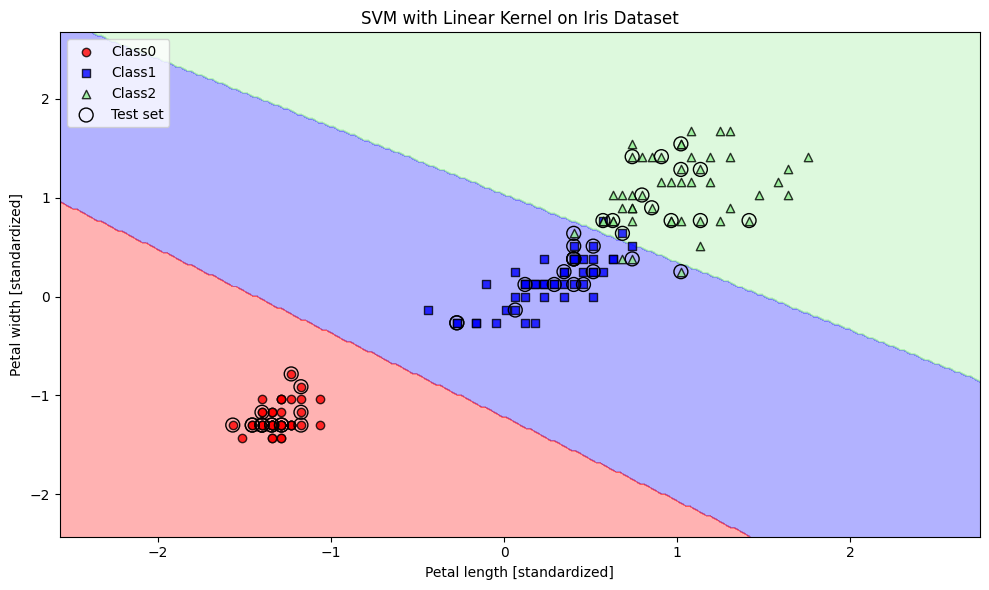

In [6]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train_std, y_train)
plt.figure(figsize=(10, 6))
plot_decision_regions(x_combined, y_combined, classifier=svm, test_idx=range(len(y_train), len(y_combined)))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.title('SVM with Linear Kernel on Iris Dataset')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Cで誤分類のペナルティを制御。正則化に関連。
Cを小さくするほどモデルのバイアスが高くなり、バリアンスが低くなる。

## 🔹 SVM の最適化問題（**ソフトマージンSVM** の場合）

SVM は以下のような **最適化問題**を解くことで分類境界（超平面）を求めます：

### 最適化問題：

$$
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i
$$

### 制約条件：

$$
y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad \text{for } i = 1, 2, ..., n
$$

---

### 🔸各記号の意味：

| 記号                   | 意味                         |
| -------------------- | -------------------------- |
| $\mathbf{w}$         | 決定境界の重みベクトル（法線ベクトル）        |
| $b$                  | バイアス（切片）                   |
| $\xi_i$              | スラック変数（誤分類やマージン違反の度合い）     |
| $C$                  | 正則化パラメータ。誤分類（スラック）のペナルティ係数 |
| $y_i \in \{-1, +1\}$ | 正解ラベル                      |
| $\mathbf{x}_i$       | 入力特徴ベクトル                   |

---

## 🔸 `C` の数式的役割：

* $\frac{1}{2} \|\mathbf{w}\|^2$：分類境界のマージンを広くしようとする（単純化への圧力）。
* $C \sum \xi_i$：誤分類やマージン違反のペナルティ（複雑化への圧力）。

つまり、

* **$C$ を大きくすると**、誤分類のペナルティが大きくなり、モデルはそれを避けようとして境界が複雑になる（過学習しやすい）。
* **$C$ を小さくすると**、多少の誤分類を許し、マージンの広い単純な境界を選ぶ（汎化性能が高まりやすい）。


In [ ]:
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss ='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

# 結局Lossの違い

## 🔹 各 `loss` の違いと対応するモデル

| モデル名      | `loss` 指定値                | 最適化される損失関数            | 学習される分類器のタイプ         |
| --------- | ------------------------- | --------------------- | -------------------- |
| パーセプトロン   | `'perceptron'`            | 誤分類したときだけ更新する（マージンなし） | 古典的なパーセプトロン          |
| ロジスティック回帰 | `'log'`（または `'log_loss'`） | ロジスティック損失（交差エントロピー）   | 確率出力あり（シグモイド関数使用）    |
| SVM（線形）   | `'hinge'`                 | ヒンジ損失                 | サポートベクターマシン（マージン最大化） |

---

## 🔸 数式で比較（損失関数）

### 1. **Perceptron（パーセプトロン）損失**:

$$
L(y, f(x)) = \max(0, -y f(x))
$$

* $y \in \{-1, 1\}$
* 誤分類したときだけ損失が正になる（ゼロ・ワン損失の近似）

---

### 2. **Log Loss（ロジスティック回帰）**:

$$
L(y, f(x)) = \log(1 + \exp(-y f(x)))
$$

* 滑らかな損失関数 → 確率的な分類器になる
* 出力にシグモイド関数を適用し、確率でクラス分けする

---

### 3. **Hinge Loss（SVM）**:

$$
L(y, f(x)) = \max(0, 1 - y f(x))
$$

* 正しく分類していても、マージンを満たさないと損失あり
* マージン最大化が目的になる（SVMの本質）

